# Libraries

In [1]:
# Loading in data:
import pandas as pd
#import feather

# Plotting:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Maps:
import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import geopandas as gpd
import shapely.geometry as geom
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import folium

# Parsing:
import requests
import requests_cache
import lxml
from bs4 import BeautifulSoup
import bs4
import re

# Other
import statsmodels
import numpy as np

#plt.rcParams['figure.figsize'] = (12,12)

# Reading in the Data

In [ ]:
#%%timeit -r1 -n1 
# timeit args from: http://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook 
# For some reason the varible isn't saved when using timeit

# Note: To just read in part add nrows =
parseDates = ["Opened", "Closed", "Updated"] # Convert these to datetimes
street_csv = pd.read_csv("Street_and_Sidewalk_Cleaning.csv", 
                         #nrows = 100000,
                         parse_dates=parseDates)


In [ ]:
# Write feather
feather.write_dataframe(street_csv, 'street.feather')

In [ ]:
# Write h5
street.to_hdf('street.h5','table',append=False)

In [2]:
# Katherine run only this
#street2 = pd.read_hdf('street.h5')
street2 = pd.HDFStore('street.h5')
street = street2.select('/table')
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  322566 2008-11-30 22:56:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
1  322560 2008-11-30 22:24:00 2009-07-21 16:24:00  Closed      DPW Ops Queue   
2  322559 2008-11-30 22:20:00 2008-12-01 06:07:00  Closed      DPW Ops Queue   
3  322556 2008-11-30 21:34:00 2008-12-09 08:07:00  Closed      DPW Ops Queue   
4  322545 2008-11-30 20:45:00 2009-02-03 07:09:00  Closed      DPW Ops Queue   

                                        Address                      Category  \
0        1566 HYDE ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
1         Intersection of TAYLOR ST and TURK ST  Street and Sidewalk Cleaning   
2  1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109  Street and Sidewalk Cleaning   
3          Intersection of 25TH ST and LUCKY ST  Street and Sidewalk Cleaning   
4        Intersection of 19TH ST and OAKWOOD ST  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source  Supervisor District  \
0  Sidewalk_Cleaning               Garbage  Voice In                  3.0   
1    Illegal_Dumping               Garbage  Voice In                  6.0   
2    Illegal_Dumping              Mattress  Voice In                  3.0   
3  Sidewalk_Cleaning  Human_waste_or_urine  Voice In                  9.0   
4  Sidewalk_Cleaning            Empty_cart  Voice In                  8.0   

            Neighborhood             Updated  \
0               Nob Hill 2009-07-21 16:24:00   
1  Downtown/Civic Center 2009-07-21 16:24:00   
2               Nob Hill 2008-12-01 06:07:00   
3                Mission 2008-12-09 08:07:00   
4                Mission 2009-02-03 07:09:00   

                                   Point  
0         (37.795328529, -122.418067787)  
1  (37.7832142923006, -122.410764953722)  
2   (37.791643509125, -122.419260423291)  
3  (37.7509362479361, -122.413364630104)  
4   (37.7598935230725, -122.42486308879)

In [3]:
# Read feather
#street = feather.read_dataframe('street.feather')

In [4]:
# To use the csv version
# street = street_csv

In [5]:
# Check if the binary version is equivalent
#all(street == street_csv)

In [6]:
# TODO: Only use this subset for some analysis, since some major events are outside this range. 
street = street.loc[street['Opened'].dt.year != 2008]
street = street.loc[street['Opened'].dt.year != 2017]
street = street.sort_values("Opened")
street = street.reset_index()
street = street.drop('index', 1)

# Some cleaning:
street.ix[street.Neighborhood == "Ocean View", "Neighborhood"] = "Oceanview"
street.ix[street.Neighborhood == "None", "Neighborhood"] = np.nan
street.ix[street.Neighborhood == "Downtown/Civic Center", "Neighborhood"] = "Civic Center"
street.ix[street.Neighborhood == "St. Mary's Park", "Neighborhood"] = "St. Marys Park"
street.ix[street.Neighborhood == "Presidio", "Neighborhood"] = "Presidio Heights"

street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  342509 2009-01-01 08:30:51 2009-01-01 11:07:06  Closed      DPW Ops Queue   
1  342510 2009-01-01 08:33:46 2009-01-01 11:07:06  Closed      DPW Ops Queue   
2  342512 2009-01-01 08:44:54 2009-01-31 13:09:53  Closed      DPW Ops Queue   
3  342514 2009-01-01 09:13:07 2009-01-01 11:07:06  Closed      DPW Ops Queue   
4  342519 2009-01-01 09:21:05 2009-01-21 06:07:13  Closed      DPW Ops Queue   

                                        Address                      Category  \
0         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
1         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
2     467 FILLMORE ST, SAN FRANCISCO, CA, 94117  Street and Sidewalk Cleaning   
3   Intersection of DWIGHT ST and GOETTINGEN ST  Street and Sidewalk Cleaning   
4  1610 MCALLISTER ST, SAN FRANCISCO, CA, 94115  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source  Supervisor District  \
0  Sidewalk_Cleaning            Encampment  Voice In                  6.0   
1  Sidewalk_Cleaning   Debris_filled_carts  Voice In                  6.0   
2    Street_Cleaning                 Glass  Voice In                  5.0   
3  Sidewalk_Cleaning               Garbage  Voice In                  9.0   
4  Sidewalk_Cleaning  Human_waste_or_urine  Voice In                  5.0   

       Neighborhood             Updated                                  Point  
0           Mission 2009-01-01 11:07:06  (37.7695911772607, -122.415577110949)  
1           Mission 2009-01-01 11:07:06  (37.7695911772607, -122.415577110949)  
2  Western Addition 2009-01-31 13:09:53         (37.773807246, -122.431027495)  
3         Excelsior 2009-01-01 11:07:06  (37.7232896018615, -122.405086927628)  
4  Western Addition 2009-01-21 06:07:13          (37.777956377, -122.43893262)

Some basic statistics on the dataset we are starting with:

In [7]:
numRows = street.shape[0]
print "We are working with", numRows, "rows."
print "Our dates range from", street.loc[numRows - 1, "Opened"],"to", street.loc[0, "Opened"], "."

We are working with 693612 rows.
Our dates range from 2016-12-31 22:59:11 to 2009-01-01 08:30:51 .


# Plots

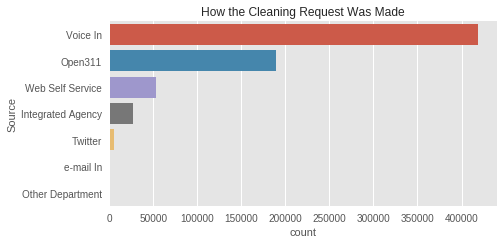

In [8]:
#plt.figure(figsize=(2,100)) # Doesn't do much
theOrder = ["Voice In", "Open311", "Web Self Service", "Integrated Agency", "Twitter", "e-mail In", "Other Department"]
#sns.set(font_scale = 1.5)
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Source", data = street, kind = "count", orient = "h", order = theOrder, aspect = 2)#, size = 10)
plt.title("How the Cleaning Request Was Made") 
plt.show()

According to [the project's website](http://www.open311.org/learn/), Open311 allows people to report issues in public spaces to city officials through a [website](https://sf311.org/index.aspx?page=797) or [mobile app](https://www.sf311.org/mobile).  

In [9]:
street.Neighborhood.value_counts

<bound method Series.value_counts of 0                              Mission
1                              Mission
2                     Western Addition
3                            Excelsior
4                     Western Addition
5                       Inner Richmond
6                       Bernal Heights
7                         Civic Center
8                       Bernal Heights
9                            Chinatown
10                      Haight Ashbury
11                           Chinatown
12                             Mission
13                      Haight Ashbury
14                      Haight Ashbury
15                      Haight Ashbury
16                             Bayview
17                             Bayview
18                            Nob Hill
19                             Bayview
20                             Bayview
21                           Excelsior
22                           Excelsior
23                             Bayview
24                         

In [10]:
# From: http://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
counts = street.groupby('Neighborhood').count()

We can get the total number of cases from CaseID
unresolved cases by neighborhood

In [11]:
counts = counts.sort_values(by = "CaseID",
                            ascending = False)
counts = counts.reset_index()
counts['UnclosedProp'] = (counts.Opened - counts.Closed) / counts.Opened
counts.head()

Neighborhood  CaseID  Opened  Closed  Status  Responsible Agency  \
0          Mission   96712   96712   95382   96712               96712   
1  South of Market   65269   65269   64275   65269               65269   
2     Civic Center   36750   36750   36542   36750               36750   
3       Tenderloin   28495   28495   28059   28495               28495   
4          Bayview   25956   25956   25658   25956               25956   

   Address  Category  Request Type  Request Details  Source  \
0    96712     96712         96700            96698   96712   
1    65269     65269         65263            65263   65269   
2    36750     36750         36749            36748   36750   
3    28495     28495         28494            28494   28495   
4    25956     25956         25956            25955   25956   

   Supervisor District  Updated  Point  UnclosedProp  
0                96712    96712  96712      0.013752  
1                65269    65269  65269      0.015229  
2                36750    36750  36750      0.005660  
3                28495    28495  28495      0.015301  
4                25956    25956  25956      0.011481

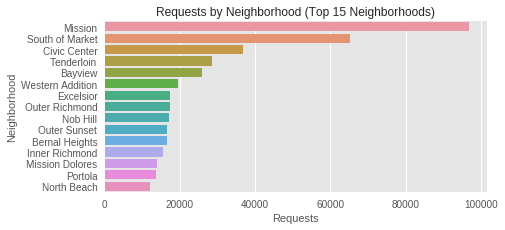

In [12]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

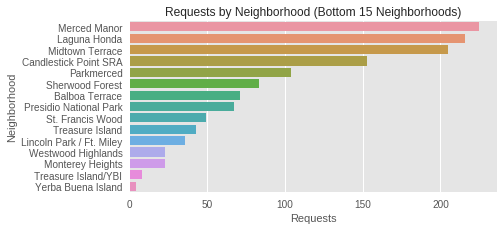

In [13]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.tail(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Bottom 15 Neighborhoods)") 
plt.show()

To get a sense of where these neighborhood fall on a map, we created this plot:

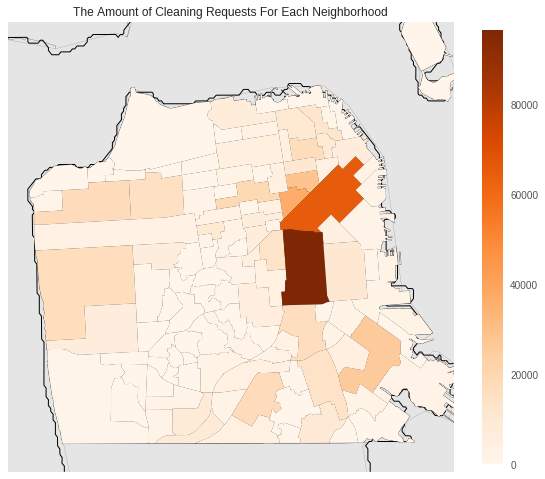

In [14]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, llcrnrlat=37.7, urcrnrlon=-122.36, urcrnrlat=37.83, resolution="f",
    projection="merc") 
myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['Opened'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['Opened'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Amount of Cleaning Requests For Each Neighborhood")

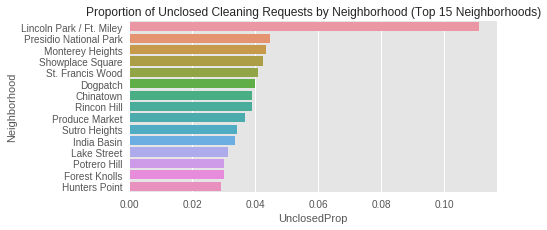

In [15]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "UnclosedProp", 
                    y = "Neighborhood",
                    data = counts.sort_values(by = "UnclosedProp",
                                              ascending = False).head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
plt.title("Proportion of Unclosed Cleaning Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

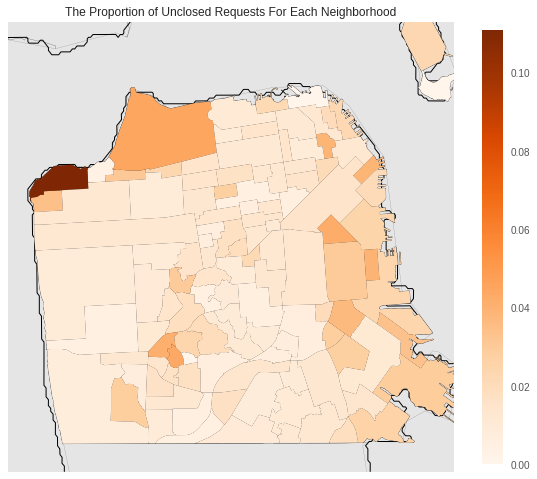

In [16]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, llcrnrlat=37.7, urcrnrlon=-122.36, urcrnrlat=37.83, resolution="f",
    projection="merc") 
myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['UnclosedProp'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['UnclosedProp'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Proportion of Unclosed Requests For Each Neighborhood")

Use supervisor district where there are too many neighborhoods. 

In [17]:
request_counts = street.groupby(by = "Request Type").count().reset_index().ix[:,["Request Type","CaseID"]].sort_values(by = "CaseID", ascending = False)
request_counts.head()

Request Type  CaseID
1           Bulky Items  173877
5      General Cleaning  166806
15    Sidewalk_Cleaning  159118
6   Hazardous Materials   77074
7    Illegal Encampment   38863

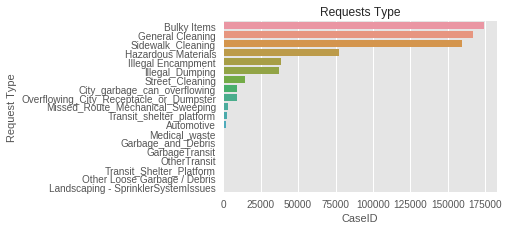

In [18]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Request Type", 
                    x = "CaseID",
                    data = request_counts, 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
plt.title("Requests Type") 
plt.show()

Differences by time of year:
- Mattresses in summer  
- Holiday shopping  


Note: only use 2009 through 2016 to only count full years.  
Ask TA if we should do this for all analysis or just this part.

In [19]:
street['month'] = [timestamp.month for timestamp in street.Opened]

In [20]:
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  342509 2009-01-01 08:30:51 2009-01-01 11:07:06  Closed      DPW Ops Queue   
1  342510 2009-01-01 08:33:46 2009-01-01 11:07:06  Closed      DPW Ops Queue   
2  342512 2009-01-01 08:44:54 2009-01-31 13:09:53  Closed      DPW Ops Queue   
3  342514 2009-01-01 09:13:07 2009-01-01 11:07:06  Closed      DPW Ops Queue   
4  342519 2009-01-01 09:21:05 2009-01-21 06:07:13  Closed      DPW Ops Queue   

                                        Address                      Category  \
0         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
1         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
2     467 FILLMORE ST, SAN FRANCISCO, CA, 94117  Street and Sidewalk Cleaning   
3   Intersection of DWIGHT ST and GOETTINGEN ST  Street and Sidewalk Cleaning   
4  1610 MCALLISTER ST, SAN FRANCISCO, CA, 94115  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source  Supervisor District  \
0  Sidewalk_Cleaning            Encampment  Voice In                  6.0   
1  Sidewalk_Cleaning   Debris_filled_carts  Voice In                  6.0   
2    Street_Cleaning                 Glass  Voice In                  5.0   
3  Sidewalk_Cleaning               Garbage  Voice In                  9.0   
4  Sidewalk_Cleaning  Human_waste_or_urine  Voice In                  5.0   

       Neighborhood             Updated  \
0           Mission 2009-01-01 11:07:06   
1           Mission 2009-01-01 11:07:06   
2  Western Addition 2009-01-31 13:09:53   
3         Excelsior 2009-01-01 11:07:06   
4  Western Addition 2009-01-21 06:07:13   

                                   Point  month  
0  (37.7695911772607, -122.415577110949)      1  
1  (37.7695911772607, -122.415577110949)      1  
2         (37.773807246, -122.431027495)      1  
3  (37.7232896018615, -122.405086927628)      1  
4          (37.777956377, -122.43893262)      1

In [21]:
count_by_month = street.groupby(by='month').count().CaseID.reset_index()
count_by_month

month  CaseID
0       1   57466
1       2   48871
2       3   50527
3       4   48875
4       5   52543
5       6   57559
6       7   60132
7       8   66023
8       9   64723
9      10   66142
10     11   62132
11     12   58619

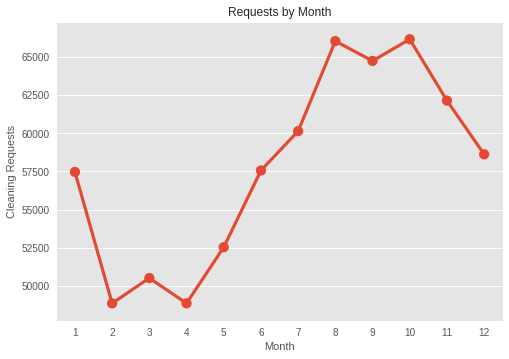

In [22]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

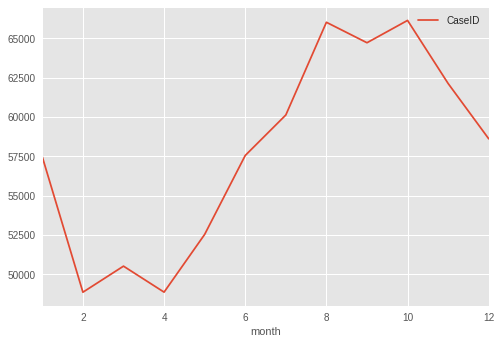

In [23]:
count_by_month.plot(y = "CaseID", 
                    x = "month")

Faster at closing requests by time?
Time to close requests by neighborhood?

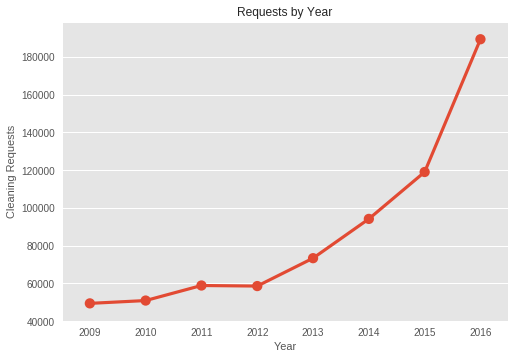

In [24]:
street['year'] = [timestamp.year for timestamp in street.Opened]
count_by_year = street.groupby(by='year').count().CaseID.reset_index()
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "year",
                    data = count_by_year, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Year")
plt.title("Requests by Year") 
plt.show()

In [25]:
[(colname, len(street[colname].unique())) for colname in list(street)]

[('CaseID', 693612),
 ('Opened', 685180),
 ('Closed', 507615),
 ('Status', 2),
 ('Responsible Agency', 122),
 ('Address', 96438),
 ('Category', 1),
 ('Request Type', 20),
 ('Request Details', 126),
 ('Source', 7),
 ('Supervisor District', 14),
 ('Neighborhood', 122),
 ('Updated', 515053),
 ('Point', 102834),
 ('month', 12),
 ('year', 8)]

In [26]:
by_month_req_type = street.groupby(by=['month','Request Type']).count().CaseID.reset_index()
by_month_req_type = by_month_req_type.sort_values(by = ['month', "CaseID"], ascending=[True,False])
by_month_req_type.head()

month         Request Type  CaseID
4       1     General Cleaning   16201
11      1    Sidewalk_Cleaning   14339
1       1          Bulky Items   12222
5       1  Hazardous Materials    5376
7       1      Illegal_Dumping    3509

In [27]:
#by_month_req_type = street.groupby(by=['month','Request Type']).plot()


In [28]:
#street.groupby(by=['month','Request Type']).plot(y = 'CaseID', x = 'month')

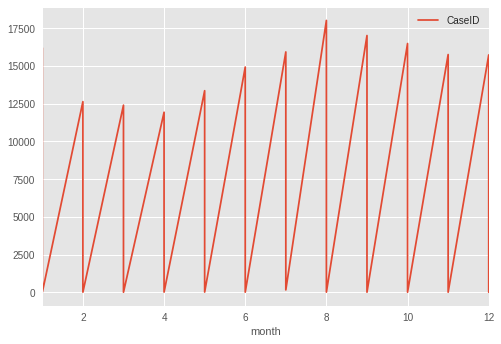

In [29]:
by_month_req_type.plot(y = 'CaseID', x = 'month')

# Scraping

In [30]:
requests_cache.install_cache('sf_cache')

In [31]:
url = "http://www.city-data.com/nbmaps/neigh-San-Francisco-California.html"
response = requests.get(url)
response.raise_for_status

neighborhoods_bs = BeautifulSoup(response.text, 'lxml')
neighborhood_names = neighborhoods_bs.find_all(name = "span", attrs={'class':'street-name'})
neighborhood_names = [name.text.replace("-", " ") for name in neighborhood_names]
neighborhood_divs = neighborhoods_bs.body.find_all(name = "div", attrs={'class':'neighborhood'})

In [32]:
def catch(line, number, simple, c = "h", complicated = False):
    """
    This function was made to catch the cases when scraping where we want NAs. If grabbing what we want from line fails, 
    then NA is returned. If number is True, then the value we are grabbing needs to be converted from a string to a number. 
    If simple is True, then the value we are scraping is right there, otherwise we need to search for a particular class which
    is the c input variable. Complicated is for the last column we are scraping where finding that class is a bit more complicated.
    """
    try:
        if number == True:
            if simple == True:
                return float(line[0].next_sibling.replace(",", "").replace("$", ""))
            
            else: 
                if complicated == False:
                    return float(line[0].next_sibling.next_sibling.find_all(class_ = c)[0].next_sibling.replace(",", "").replace(" years", "").replace("$", ""))
                else: 
                    return float(line[0].find_all_next(class_ = c)[0].next_sibling.replace(",", "").replace(" years", "").replace("$", ""))

        else:
            return line[0].next_sibling
    except:
        return np.nan

In [33]:
demographic = pd.DataFrame({
        'Neighborhood': neighborhood_names, 
        'AreaSqMi': [catch(neigh.find_all(name = "b", string = "Area:"), True, True) for neigh in neighborhood_divs] ,
        'Population': [catch(neigh.find_all(name = "b", string = "Population:"), True, True) for neigh in neighborhood_divs], 
        'PeoplePerSqMi': [catch(neigh.find_all(name = "b", string = "Population density:"), True, False) for neigh in neighborhood_divs],
        'MedHouseholdIncome': [catch(neigh.find_all(name = "b", string = "Median household income in 2015: "), True, False) for neigh in neighborhood_divs],
        'MedRent': [catch(neigh.find_all(name = "b", string = "Median rent in in 2015: "), True, False) for neigh in neighborhood_divs],
        'Males': [catch(neigh.find_all(name = "b", string = "Male vs Females"), True, False) for neigh in neighborhood_divs],
        'Females': [catch(neigh.find_all(name = "b", string = "Male vs Females"), True, False, "a") for neigh in neighborhood_divs], 
        'MedAgeM': [catch(neigh.find_all(name = "b", string = "Median age"), True, False) for neigh in neighborhood_divs],
        'MedAgeF': [catch(neigh.find_all(name = "b", string = "Median age"), True, False, "a") for neigh in neighborhood_divs],
        'HousePrice': [catch(neigh.find_all(name = "b", string = "Average estimated value of detached houses in 2015 "), True, False, complicated = True) for neigh in neighborhood_divs],
})

demographic.head()

AreaSqMi  Females  HousePrice   Males  MedAgeF  MedAgeM  \
0     0.144   2461.0   1988926.0  3916.0     38.6     35.4   
1     0.124    944.0    455053.0  1177.0     38.9     41.2   
2     0.037     96.0   1101672.0   145.0     48.2     48.4   
3     0.055    774.0         NaN  1365.0     35.2     35.1   
4     0.048    312.0         NaN   377.0     42.6     38.6   

   MedHouseholdIncome  MedRent  Neighborhood  PeoplePerSqMi  Population  
0             93901.0   1754.0  Alamo Square        44418.0      6379.0  
1            104697.0   1937.0    Anza Vista        17080.0      2122.0  
2            139017.0   2014.0  Aquatic Park         6487.0       241.0  
3            134523.0   2489.0      Baja Noe        38816.0      2141.0  
4             84685.0   1591.0   Balboa Park        14350.0       690.0

In [34]:
def CombineNeighs(name1, name2, newName, df):
    """
    This function takes in two neighborhood names of the demographic dataframe, combines them, and changes the name.
    """
    one = df.ix[df.Neighborhood == name1]
    two = df.ix[df.Neighborhood == name2]
    one.loc[one.index, "AreaSqMi"] = (one['AreaSqMi'].values[0] + two['AreaSqMi'].values[0]) / 2
    one.loc[one.index, 'Females'] = one['Females'].values[0] + two['Females'].values[0]
    one.loc[one.index, 'HousePrice'] = (one['HousePrice'].values[0] + two['HousePrice'].values[0]) / 2
    one.loc[one.index, 'Males'] = one['Males'].values[0] + two['Males'].values[0]
    one.loc[one.index, 'MedAgeF'] = (one['MedAgeF'].values[0] + two['MedAgeF'].values[0]) / 2
    one.loc[one.index, 'MedAgeM'] = (one['MedAgeM'].values[0] + two['MedAgeM'].values[0]) / 2
    one.loc[one.index, 'MedHouseholdIncome'] = (one['MedHouseholdIncome'].values[0] + two['MedHouseholdIncome'].values[0]) / 2
    one.loc[one.index, 'PeoplePerSqMi'] = (one['PeoplePerSqMi'].values[0] + two['PeoplePerSqMi'].values[0]) / 2
    one.loc[one.index, 'Population'] = one['Population'].values[0] + two['Population'].values[0]   
    one.loc[one.index, 'Neighborhood'] = newName
    df = df.drop(one.index)
    df = df.drop(two.index)
    df = df.append(one)
    return df

In [35]:
# Clean up neighborhood names: make the demographic names match our data and shapefiles
demographic = CombineNeighs("Bayview District", "Bayview Heights", "Bayview", demographic)
demographic = CombineNeighs("Bernal Heights North", "Bernal Heights Park", "Bernal Heights1", demographic)
demographic = CombineNeighs("Bernal Heights South", "Bernal Heights", "Bernal Heights2", demographic)
demographic = CombineNeighs("Bernal Heights1", "Bernal Heights2", "Bernal Heights", demographic)
demographic = CombineNeighs("Balboa Park", "Balboa Terrace", "Balboa Terrace", demographic)
demographic = CombineNeighs("Aquatic Park", "Fort Mason", 'Aquatic Park / Ft. Mason', demographic)
demographic = CombineNeighs("Downtown", "Union Square", 'Downtown / Union Square', demographic)
demographic = CombineNeighs("Financial District", "Financial District South", "Financial District", demographic)


/home/tgordon/.local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:

demographic.loc[demographic.Neighborhood == "Buena Vista Park", "Neighborhood"] = "Buena Vista"
demographic.loc[demographic.Neighborhood == "Cayuga Terrace", "Neighborhood"] = "Cayuga"
demographic.loc[demographic.Neighborhood == "Ingleside Terrace", "Neighborhood"] = "Ingleside Terraces"
demographic.loc[demographic.Neighborhood == "Laurel Heights", "Neighborhood"] = 'Laurel Heights / Jordan Park'
demographic.loc[demographic.Neighborhood == "Lake Shore", "Neighborhood"] = 'Lakeshore'
demographic.loc[demographic.Neighborhood == "South Of Market", "Neighborhood"] = 'South of Market'
demographic.loc[demographic.Neighborhood == "North Waterfront", "Neighborhood"] = 'Northern Waterfront'
demographic.loc[demographic.Neighborhood == "St Marys Square", "Neighborhood"] = "St. Marys Park"
demographic.loc[demographic.Neighborhood == "Saint Francis Wood", "Neighborhood"] = "St. Francis Wood"
demographic.loc[demographic.Neighborhood == "Sea Cliff", "Neighborhood"] = "Seacliff"
demographic.loc[demographic.Neighborhood == "Parnassus", "Neighborhood"] = "Parnassus Heights"
demographic.loc[demographic.Neighborhood == "Park Merced", "Neighborhood"] = "Parkmerced"
demographic.loc[demographic.Neighborhood == "Mission District", "Neighborhood"] = "Mission"
demographic.loc[demographic.Neighborhood == "Marina District", "Neighborhood"] = "Marina"
demographic.loc[demographic.Neighborhood == "Mount Davidson Manor", "Neighborhood"] = "Mt. Davidson Manor"
demographic.loc[demographic.Neighborhood == "Lake", "Neighborhood"] = "Lake Street"

In [37]:
# set(street.Neighborhood.unique()) - set(demographic.Neighborhood.unique())

In [38]:
street = street.merge(demographic, on = "Neighborhood", how = "left") 
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  342509 2009-01-01 08:30:51 2009-01-01 11:07:06  Closed      DPW Ops Queue   
1  342510 2009-01-01 08:33:46 2009-01-01 11:07:06  Closed      DPW Ops Queue   
2  342512 2009-01-01 08:44:54 2009-01-31 13:09:53  Closed      DPW Ops Queue   
3  342514 2009-01-01 09:13:07 2009-01-01 11:07:06  Closed      DPW Ops Queue   
4  342519 2009-01-01 09:21:05 2009-01-21 06:07:13  Closed      DPW Ops Queue   

                                        Address                      Category  \
0         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
1         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
2     467 FILLMORE ST, SAN FRANCISCO, CA, 94117  Street and Sidewalk Cleaning   
3   Intersection of DWIGHT ST and GOETTINGEN ST  Street and Sidewalk Cleaning   
4  1610 MCALLISTER ST, SAN FRANCISCO, CA, 94115  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source     ...      AreaSqMi  \
0  Sidewalk_Cleaning            Encampment  Voice In     ...         1.481   
1  Sidewalk_Cleaning   Debris_filled_carts  Voice In     ...         1.481   
2    Street_Cleaning                 Glass  Voice In     ...         0.368   
3  Sidewalk_Cleaning               Garbage  Voice In     ...         1.073   
4  Sidewalk_Cleaning  Human_waste_or_urine  Voice In     ...         0.368   

   Females HousePrice    Males  MedAgeF  MedAgeM  MedHouseholdIncome  MedRent  \
0  20187.0   799159.0  25373.0     36.9     36.2             96288.0   1461.0   
1  20187.0   799159.0  25373.0     36.9     36.2             96288.0   1461.0   
2   7563.0  1334029.0   6883.0     47.9     39.6             66992.0   1139.0   
3  16907.0   570545.0  17096.0     44.7     40.9             79346.0   1611.0   
4   7563.0  1334029.0   6883.0     47.9     39.6             66992.0   1139.0   

   PeoplePerSqMi  Population  
0        30764.0     45565.0  
1        30764.0     45565.0  
2        39272.0     14446.0  
3        31684.0     34003.0  
4        39272.0     14446.0  

[5 rows x 26 columns]

--------

## Events and Festivals

In [39]:
url_pride = "https://en.wikipedia.org/wiki/San_Francisco_Pride"
response = requests.get(url_pride)
response.raise_for_status

pride_bs = BeautifulSoup(response.text, 'lxml')

pride_table = pride_bs.find_all(name = "table", attrs={'class':'wikitable'})


In [40]:
#type(pride_table[0])
# The table is the first element

rows = pride_table[0].find_all(name = "tr")

# The first row is the header
#print rows[0]
#for colname in rows[0].find_all(name = "th"):
#    print colname.text

colnames = [colname.text for colname in rows[0].find_all(name = "th")]
print colnames

#pride = [{colname, []} for colname in colnames]
#print pride

[u'Year', u'Dates', u'Festival name', u'Theme', u'Estimated attendance', u'Notes']


In [41]:
years = []
dates = []
attendance = []

for row in rows[1:]:
    cells = row.find_all(name = "td")
        
    years.append(cells[0].text)
    dates.append(cells[1].text)
    attendance.append(cells[4].text)
    
assert(len(years) == len(dates) == len(attendance))

In [42]:
pride = pd.DataFrame.from_dict({"year": years,
                                "date": dates,
                                "attendance": attendance})

pride.year = pd.to_numeric(pride.year)

# Remove unused years
pride = pride[pride.year > 2007]

pride

attendance        date  year
38  1.2 million[25]  June 28–29  2008
39  1.2 million[26]  June 27–28  2009
40  1.2 million[27]  June 26–27  2010
41    1 million[28]  June 25–26  2011
42                   June 23–24  2012
43      1.5 Million  June 29–30  2013
44      1.7 million  June 28–29  2014
45      1.8 million  June 27–28  2015
46              TBD  June 25-26  2016

In [45]:
#pride.date[0][-2:]

In [46]:
startdates = [d[:-3] for d in pride.date]
enddates = [d[:4] + d[-2:] for d in pride.date]
startdatetimes = []
enddatetimes = []

for sdate, edate, year in zip(startdates, enddates, pride.year):
    startdatetimes.append(sdate + " " + str(year))
    enddatetimes.append(edate + " " + str(year))
    
pride["start_date"] = pd.to_datetime(startdatetimes)
pride["end_date"] = pd.to_datetime(enddatetimes)
#pride["datetimes"] = [pd.date_range(dt, periods=2) for dt in startdatetimes]
pride

attendance        date  year start_date   end_date
38  1.2 million[25]  June 28–29  2008 2008-06-28 2008-06-29
39  1.2 million[26]  June 27–28  2009 2009-06-27 2009-06-28
40  1.2 million[27]  June 26–27  2010 2010-06-26 2010-06-27
41    1 million[28]  June 25–26  2011 2011-06-25 2011-06-26
42                   June 23–24  2012 2012-06-23 2012-06-24
43      1.5 Million  June 29–30  2013 2013-06-29 2013-06-30
44      1.7 million  June 28–29  2014 2014-06-28 2014-06-29
45      1.8 million  June 27–28  2015 2015-06-27 2015-06-28
46              TBD  June 25-26  2016 2016-06-25 2016-06-26

In [47]:
def parse_attendance(attendance_str):
    """
    
    """
    
    if "million" in attendance_str.lower():
        # Multiply by 1000000 and remove the string "million"
        return float(attendance_str.split(" ")[0]) * 1000000
    
    else:
        return None

        
pride["attendance_num"] = [parse_attendance(x) for x in pride.attendance]
pride

attendance        date  year start_date   end_date  attendance_num
38  1.2 million[25]  June 28–29  2008 2008-06-28 2008-06-29       1200000.0
39  1.2 million[26]  June 27–28  2009 2009-06-27 2009-06-28       1200000.0
40  1.2 million[27]  June 26–27  2010 2010-06-26 2010-06-27       1200000.0
41    1 million[28]  June 25–26  2011 2011-06-25 2011-06-26       1000000.0
42                   June 23–24  2012 2012-06-23 2012-06-24             NaN
43      1.5 Million  June 29–30  2013 2013-06-29 2013-06-30       1500000.0
44      1.7 million  June 28–29  2014 2014-06-28 2014-06-29       1700000.0
45      1.8 million  June 27–28  2015 2015-06-27 2015-06-28       1800000.0
46              TBD  June 25-26  2016 2016-06-25 2016-06-26             NaN

In [48]:
pride = pride.reset_index()

### Outside Lands Music and Arts Festival

In [49]:
url_ol = "https://en.wikipedia.org/wiki/Outside_Lands_Music_and_Arts_Festival"
response = requests.get(url_ol)
response.raise_for_status

ol_bs = BeautifulSoup(response.text, 'lxml')


# Years are in h3
h3 = ol_bs.find_all(name = "h3")

ol = []

for h in h3:
    span = h.find_all(name = "span", attrs={"class":"mw-headline"})
    
    # If there is a span in the h3
    if span:
        year = span[0].text
        #print year 
        
        check_p = True
        
        #dates = []
        
        for sibling in h.find_next_siblings(limit=5):
            
            # Days are in h4 or p
            if sibling.name == "h4":
                #print "h4" + "\t" + sibling.text
                ol.append([year, sibling.text.replace(u"\u2013", "-").replace("[edit]","")])
                # If an h4 was found, stop looking for p
                check_p = False
                
            elif sibling.name == "p" and check_p:
                #print check_p
                #print "p" + "\t" + sibling.text
                ol.append([year, sibling.text.replace(u"\u2013", "-")])
                # Formatting for 2011+ uses the date in a p tag
                if "August" in sibling.text:
                    break
                
        #print "\n"
        #ol[str(year)] = dates

ol

[[u'2008', u'Friday August 22'],
 [u'2008', u'Saturday August 23'],
 [u'2008', u'Sunday August 24'],
 [u'2009', u'Friday August 28'],
 [u'2009', u'Saturday August 29'],
 [u'2010', u'Saturday August 14'],
 [u'2010', u'Sunday August 15'],
 [u'2011', u'August 12-14'],
 [u'2012', u'August 10-12'],
 [u'2013', u'August 9-11'],
 [u'2014', u'August 8-10'],
 [u'2015', u'August 7-9'],
 [u'2016', u'August 5-9']]

In [50]:
# Separate the date ranges and fix the formatting

ol2 = []
for year_and_date in ol:
    
    date_split = year_and_date[1].split()
    month = date_split[0]
    if len(date_split) > 2:
        # keep the year
        year_and_date_new = [year_and_date[0]]
        year_and_date_new.extend(date_split[1:])
        ol2.append(year_and_date_new)
    else:
        days = date_split[1].split("-")
        for day in days:
            # keep the year
            year_and_date_new = [year_and_date[0]]
            year_and_date_new.append(month)
            year_and_date_new.append(day)
            ol2.append(year_and_date_new)

ol2

[[u'2008', u'August', u'22'],
 [u'2008', u'August', u'23'],
 [u'2008', u'August', u'24'],
 [u'2009', u'August', u'28'],
 [u'2009', u'August', u'29'],
 [u'2010', u'August', u'14'],
 [u'2010', u'August', u'15'],
 [u'2011', u'August', u'12'],
 [u'2011', u'August', u'14'],
 [u'2012', u'August', u'10'],
 [u'2012', u'August', u'12'],
 [u'2013', u'August', u'9'],
 [u'2013', u'August', u'11'],
 [u'2014', u'August', u'8'],
 [u'2014', u'August', u'10'],
 [u'2015', u'August', u'7'],
 [u'2015', u'August', u'9'],
 [u'2016', u'August', u'5'],
 [u'2016', u'August', u'9']]

In [51]:
ol_dates = pd.to_datetime([" ".join(date) for date in ol2])
ol_dates

DatetimeIndex(['2008-08-22', '2008-08-23', '2008-08-24', '2009-08-28',
               '2009-08-29', '2010-08-14', '2010-08-15', '2011-08-12',
               '2011-08-14', '2012-08-10', '2012-08-12', '2013-08-09',
               '2013-08-11', '2014-08-08', '2014-08-10', '2015-08-07',
               '2015-08-09', '2016-08-05', '2016-08-09'],
              dtype='datetime64[ns]', freq=None)

# Events Plots

Grab all of June and group by day to get count of requests, then add boolean pride or not

In [52]:
streetJune = street.loc[street["Opened"].dt.month == 6]
streetJune["DateOpened"] = streetJune["Opened"].dt.date # Yells at you

# http://www.sfpride.org/parade/
prideNeighs = ["South of Market", "Tenderloin", "Financial District", "Downtown / Union Square", "Civic Center"]
streetJune = streetJune.loc[streetJune.Neighborhood.isin(prideNeighs)]

JuneDayReqs = streetJune.groupby(by = "DateOpened").count().CaseID
pride["StartNoTime"] = pride["start_date"].dt.date 
pride["EndNoTime"] = pride["end_date"].dt.date 
JuneRequests = pd.DataFrame({"ReqCount": JuneDayReqs})
JuneRequests = JuneRequests.reset_index()
JuneRequests["Pride"] = [row in pride.StartNoTime.values for row in JuneRequests.DateOpened]

/home/tgordon/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [53]:
streetJune.head()

CaseID              Opened              Closed  Status  \
19953  441365 2009-06-01 05:59:27 2009-06-03 06:11:11  Closed   
19954  441366 2009-06-01 06:04:06 2009-06-02 08:10:47  Closed   
19961  441383 2009-06-01 07:07:34 2009-06-02 08:10:45  Closed   
19966  441393 2009-06-01 07:23:06 2009-06-03 06:11:01  Closed   
20009  441488 2009-06-01 09:23:58 2009-06-11 07:10:53  Closed   

      Responsible Agency                                       Address  \
19953      DPW Ops Queue      34 SHERIDAN ST, SAN FRANCISCO, CA, 94103   
19954      DPW Ops Queue          Intersection of 6TH ST and NATOMA ST   
19961      DPW Ops Queue  Intersection of GOLDEN GATE AVE and GOUGH ST   
19966      DPW Ops Queue    519 STEVENSON ST, SAN FRANCISCO, CA, 94103   
20009      DPW Ops Queue         160 PINE ST, SAN FRANCISCO, CA, 94111   

                           Category       Request Type    Request Details  \
19953  Street and Sidewalk Cleaning    Illegal_Dumping          Furniture   
19954  Street and Sidewalk Cleaning    Street_Cleaning            Garbage   
19961  Street and Sidewalk Cleaning  Sidewalk_Cleaning          Furniture   
19966  Street and Sidewalk Cleaning  Sidewalk_Cleaning            Garbage   
20009  Street and Sidewalk Cleaning  Sidewalk_Cleaning  Sidewalk_Cleaning   

         Source     ...      Females HousePrice   Males MedAgeF  MedAgeM  \
19953  Voice In     ...       4643.0        NaN  6977.0   40.00    39.60   
19954  Voice In     ...       4643.0        NaN  6977.0   40.00    39.60   
19961  Voice In     ...       6382.0        NaN  7892.0   44.70    42.60   
19966  Voice In     ...       4643.0        NaN  6977.0   40.00    39.60   
20009  Voice In     ...       5602.0        NaN  8189.0   46.35    43.65   

       MedHouseholdIncome  MedRent  PeoplePerSqMi  Population  DateOpened  
19953             92455.0   1047.0        18297.0     11623.0  2009-06-01  
19954             92455.0   1047.0        18297.0     11623.0  2009-06-01  
19961             64841.0   1488.0        36530.0     14275.0  2009-06-01  
19966             92455.0   1047.0        18297.0     11623.0  2009-06-01  
20009             63703.0   1050.0        13832.5     13794.0  2009-06-01  

[5 rows x 27 columns]

In [54]:
pride_merged_start = JuneRequests.merge(right = pride, right_on="StartNoTime", left_on="DateOpened")
pride_merged_end = JuneRequests.merge(right = pride, right_on="EndNoTime", left_on="DateOpened")
cols = ["DateOpened", "ReqCount", "attendance_num", "StartNoTime", "EndNoTime"]
pride_merged_start = pride_merged_start[cols]
pride_merged_end = pride_merged_end[cols]
pride_merged = pd.concat([pride_merged_start, pride_merged_end])
pride_merged["Year"] = [t.year for t in pride_merged.StartNoTime]
req_year = pride_merged.groupby(by="Year").sum()
req_year.reset_index(inplace=True)
pride_merged_final = pride_merged_start
pride_merged_final["Year"] = [t.year for t in pride_merged_final.StartNoTime]
pride_merged_final = pride_merged_final.merge(req_year, on = "Year")
pride_merged_final = pride_merged_final[["DateOpened", "ReqCount_y", "attendance_num_x", "Year","StartNoTime", "EndNoTime"]]
pride_merged_final

DateOpened  ReqCount_y  attendance_num_x  Year StartNoTime   EndNoTime
0  2009-06-27          39         1200000.0  2009  2009-06-27  2009-06-28
1  2010-06-26          61         1200000.0  2010  2010-06-26  2010-06-27
2  2011-06-25          63         1000000.0  2011  2011-06-25  2011-06-26
3  2012-06-23          56               NaN  2012  2012-06-23  2012-06-24
4  2013-06-29          37         1500000.0  2013  2013-06-29  2013-06-30
5  2014-06-28          62         1700000.0  2014  2014-06-28  2014-06-29
6  2015-06-27          68         1800000.0  2015  2015-06-27  2015-06-28
7  2016-06-25         108               NaN  2016  2016-06-25  2016-06-26

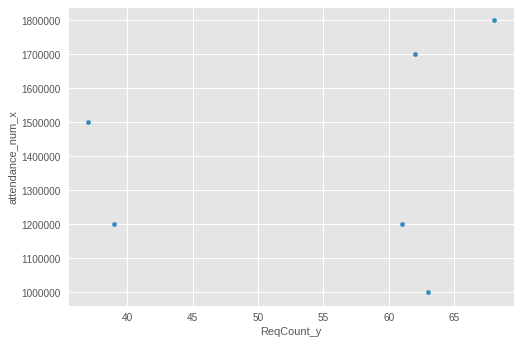

In [55]:
pride_merged_final.plot(x="ReqCount_y", y="attendance_num_x", kind="scatter")

There does not seem to be an association between the pride parade and requests in the surrounding neighborhoods.  

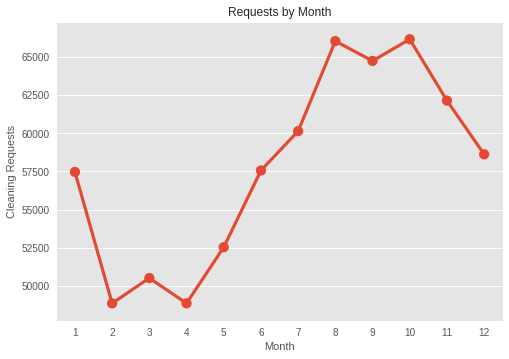

In [56]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

# Outside Lands Plot

In [57]:
ol_dates

DatetimeIndex(['2008-08-22', '2008-08-23', '2008-08-24', '2009-08-28',
               '2009-08-29', '2010-08-14', '2010-08-15', '2011-08-12',
               '2011-08-14', '2012-08-10', '2012-08-12', '2013-08-09',
               '2013-08-11', '2014-08-08', '2014-08-10', '2015-08-07',
               '2015-08-09', '2016-08-05', '2016-08-09'],
              dtype='datetime64[ns]', freq=None)

In [58]:
AugustRequests = street.loc[street["Opened"].dt.month == 8]
AugustRequests["DateOpened"] = AugustRequests["Opened"].dt.date # Yells at you
OLNeighs = ["Golden Gate Park"]
AugustRequests = AugustRequests.loc[AugustRequests.Neighborhood.isin(OLNeighs)]

/home/tgordon/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [59]:
type(AugustRequests["DateOpened"][29006])

datetime.date

In [60]:
type(ol_dates[0])

pandas.tslib.Timestamp

In [61]:
ol_dt = [d.date() for d in ol_dates]

In [62]:
AugustRequests[AugustRequests.DateOpened.isin(ol_dt)]

CaseID              Opened              Closed  Status  \
32970    495616 2009-08-29 01:47:56 2009-08-29 06:11:13  Closed   
33066    495991 2009-08-29 23:39:54 2009-09-08 07:11:14  Closed   
81611    713505 2010-08-15 09:32:01 2010-08-16 13:19:07  Closed   
136288   939648 2011-08-12 13:22:16 2011-08-18 07:06:02  Closed   
136552   940673 2011-08-14 16:54:19 2011-08-16 18:06:08  Closed   
262024  2694859 2013-08-09 08:05:03 2013-08-09 15:09:24  Closed   
262061  2695371 2013-08-09 10:01:10 2013-08-09 14:02:06  Closed   
262062  2695419 2013-08-09 10:10:58 2013-08-09 14:01:34  Closed   
262089  2695800 2013-08-09 11:15:47 2013-08-09 16:32:14  Closed   
347823  3899248 2014-08-08 12:12:03 2014-08-08 12:30:20  Closed   
347827  3899282 2014-08-08 12:22:15 2014-08-08 12:54:39  Closed   
348438  3905334 2014-08-10 19:18:51 2014-08-11 10:12:05  Closed   
455336  4977794 2015-08-07 21:56:33 2015-08-08 03:00:30  Closed   
616446  6161504 2016-08-05 11:39:50 2016-08-05 12:49:10  Closed   

        Responsible Agency                                   Address  \
32970        DPW Ops Queue  Intersection of 20TH AVE and LINCOLN WAY   
33066        DPW Ops Queue    Intersection of 36TH AVE and FULTON ST   
81611        DPW Ops Queue   Intersection of 9TH AVE and LINCOLN WAY   
136288       DPW Ops Queue  Intersection of 16TH AVE and LINCOLN WAY   
136552       DPW Ops Queue    Intersection of 25TH AVE and FULTON ST   
262024  Recology_Abandoned  Intersection of 30TH AVE and LINCOLN WAY   
262061  Recology_Abandoned    Intersection of 14TH AVE and FULTON ST   
262062  Recology_Abandoned  Intersection of 23RD AVE and LINCOLN WAY   
262089  Recology_Abandoned  Intersection of 18TH AVE and LINCOLN WAY   
347823  Recology_Abandoned  Intersection of 23RD AVE and LINCOLN WAY   
347827  Recology_Abandoned  Intersection of LINCOLN WAY and 16TH AVE   
348438  Recology_Abandoned    Intersection of FULTON ST and 33RD AVE   
455336       DPW Ops Queue    Intersection of KEZAR DR and WALLER ST   
616446  Recology_Abandoned  Intersection of 23RD AVE and LINCOLN WAY   

                            Category        Request Type      Request Details  \
32970   Street and Sidewalk Cleaning     Street_Cleaning      Street_Cleaning   
33066   Street and Sidewalk Cleaning   Sidewalk_Cleaning              Garbage   
81611   Street and Sidewalk Cleaning     Street_Cleaning      Street_Cleaning   
136288  Street and Sidewalk Cleaning   Sidewalk_Cleaning            Furniture   
136552  Street and Sidewalk Cleaning   Sidewalk_Cleaning             Mattress   
262024  Street and Sidewalk Cleaning         Bulky Items          Electronics   
262061  Street and Sidewalk Cleaning         Bulky Items         Refrigerator   
262062  Street and Sidewalk Cleaning    General Cleaning  Other Loose Garbage   
262089  Street and Sidewalk Cleaning         Bulky Items         Refrigerator   
347823  Street and Sidewalk Cleaning         Bulky Items             Mattress   
347827  Street and Sidewalk Cleaning         Bulky Items            Furniture   
348438  Street and Sidewalk Cleaning    General Cleaning  Other Loose Garbage   
455336  Street and Sidewalk Cleaning  Illegal Encampment              Storage   
616446  Street and Sidewalk Cleaning         Bulky Items         Refrigerator   

                   Source     ...      Females HousePrice Males MedAgeF  \
32970            Voice In     ...         67.0  9235775.0  58.0    37.9   
33066            Voice In     ...         67.0  9235775.0  58.0    37.9   
81611            Voice In     ...         67.0  9235775.0  58.0    37.9   
136288           Voice In     ...         67.0  9235775.0  58.0    37.9   
136552           Voice In     ...         67.0  9235775.0  58.0    37.9   
262024           Voice In     ...         67.0  9235775.0  58.0    37.9   
262061  Integrated Agency     ...         67.0  9235775.0  58.0    37.9   
262062           Voice In     ...         67.0  9235775.0  58.0    37.9   
262089  Integrated Agency     .

todo: compare to normal # of requests

--------

## Maps

In [63]:
# Coordinates from https://en.wikipedia.org/wiki/San_Francisco and 
# http://andrew.hedges.name/experiments/convert_lat_long/
m = folium.Map(location=[37.783, -122.416], zoom_start=12)
m

In [64]:
# Points
street.ix[1,'Point']

'(37.7695911772607, -122.415577110949)'

In [65]:
def to_coordinates(point):
    """
    Converts a string in the format '(37.7695911772607, -122.415577110949)' to coordinates.
    """
    
    # Tests
    assert(isinstance(point, str) and point.startswith('(') and point.endswith(')'))
    
    (lat, lon) = point.split(',')
    
    # Remove '('
    lat = lat[1:]
    
    # Remove ')' and space
    lon = lon[:-1].strip()
    
    
    
    return (float(lat), float(lon))
    
to_coordinates(street.ix[1,'Point'])

(37.7695911772607, -122.415577110949)

In [66]:
# TODO: Make this a function
folium.Marker(to_coordinates(street.ix[1,'Point']), popup = street.ix[1,'Request Type']).add_to(m)
m

In [67]:
street_mattress = street[street["Request Details"] == "Mattress"]
street_mattress.head(2)

CaseID              Opened              Closed  Status Responsible Agency  \
29  342583 2009-01-01 12:15:09 2009-01-04 06:07:17  Closed      DPW Ops Queue   
31  342596 2009-01-01 12:37:59 2009-01-03 16:07:09  Closed      DPW Ops Queue   

                                        Address                      Category  \
29   135 HIGHLAND AVE, SAN FRANCISCO, CA, 94110  Street and Sidewalk Cleaning   
31      Intersection of BEAVER ST and CASTRO ST  Street and Sidewalk Cleaning   

       Request Type Request Details    Source     ...      AreaSqMi  Females  \
29  Illegal_Dumping        Mattress  Voice In     ...         0.531  25097.0   
31  Illegal_Dumping        Mattress  Voice In     ...           NaN      NaN   

   HousePrice    Males  MedAgeF  MedAgeM  MedHouseholdIncome  MedRent  \
29   974149.5  25997.0   39.125    38.35            123137.5   1978.0   
31        NaN      NaN      NaN      NaN                 NaN      NaN   

    PeoplePerSqMi  Population  
29       21183.25     51096.0  
31            NaN         NaN  

[2 rows x 26 columns]

In [68]:
len(street_mattress)

59228

In [69]:
#from IPython.display import display
for index, row in street_mattress.iterrows():
    #print type(row["Status"])
    pass
    # Add to the map with marker cluster?
    # http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_clustered_markes.ipynb
    

In [70]:
mattress_map = folium.Map(location=[37.783, -122.416], zoom_start=12)
folium.GeoJson(open('Analysis Neighborhoods.geojson'), name='geojson').add_to(mattress_map)
mattress_map

In [71]:
# Neighborhood geojson from 
# https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

folium.GeoJson(open('Analysis Neighborhoods.geojson'), name='geojson').add_to(m)
m

Map of neighborhoods shaded by count of requests: